<a href="https://colab.research.google.com/github/raceregos/raceregos/blob/main/myWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Job Group Counts:
 job_group
Data/AI        1345
Engineering    1011
Business        840
Software        505
Other           504
Management      338
HR              169
Name: count, dtype: int64

Evaluation Metrics:
Accuracy: 0.3041018387553041
Precision: 0.48557924892424154
Recall: 0.2154892141820153
F1 Score: 0.21404520887487946


<Figure size 1000x800 with 0 Axes>

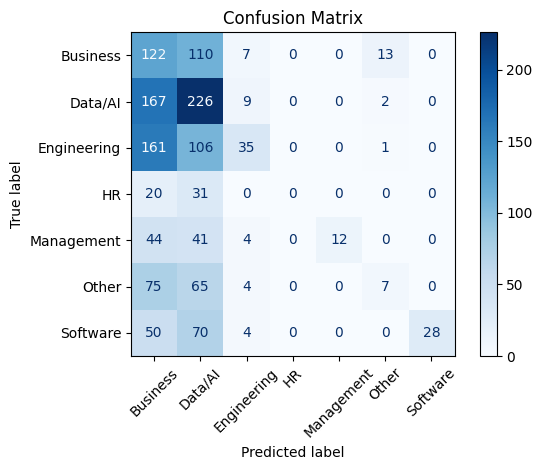

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
df = pd.read_csv('resume_data.csv')
df.columns = df.columns.str.replace('\ufeff', '')  # remove BOM

# Drop rows with missing values
df = df.dropna(subset=['job_position_name', 'career_objective', 'skills'])

# Clean skills column
df['skills'] = df['skills'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else '')

# Fill missing values in other text columns
for col in ['responsibilities', 'positions', 'related_skils_in_job']:
    if col in df.columns:
        df[col] = df[col].astype(str).fillna('')

# Combine features into single text
df['full_text'] = (
    df['career_objective'] + ' ' +
    df['skills'] + ' ' +
    df['responsibilities'] + ' ' +
    df['positions'] + ' ' +
    df['related_skils_in_job']
)

# Group job categories
def group_job(title):
    title = title.lower()
    if 'data' in title or 'ai' in title or 'ml' in title:
        return 'Data/AI'
    elif 'software' in title or 'developer' in title or 'ios' in title or 'android' in title:
        return 'Software'
    elif 'civil' in title or 'engineer' in title:
        return 'Engineering'
    elif 'manager' in title or 'coordinator' in title:
        return 'Management'
    elif 'hr' in title or 'human resource' in title:
        return 'HR'
    elif 'business' in title or 'executive' in title:
        return 'Business'
    else:
        return 'Other'

df['job_group'] = df['job_position_name'].apply(group_job)

# Encode target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['job_group'])

# Feature data
X = df['full_text']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Pipeline with TF-IDF and KNN using cosine distance
pipeline = make_pipeline(
    TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        max_df=0.9,
        min_df=2
    ),
    KNeighborsClassifier(metric='cosine', n_neighbors=5)
)

# Train
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluation
print("\nJob Group Counts:\n", df['job_group'].value_counts())
print("\nEvaluation Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro', zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro', zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, average='macro', zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
